In [41]:
import tensorflow as tf
import tensorboard as tb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Resizing, Rescaling
from tensorflow.keras.layers import RandomRotation, RandomFlip, RandomContrast
from tensorflow.keras.layers import Input, Dropout, Conv2D, MaxPool2D, Dense, Flatten
from tensorflow.keras.layers import InputLayer, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import (
    BinaryAccuracy,
    TruePositives,
    FalsePositives,
    TrueNegatives,
    FalseNegatives,
    AUC,
    Precision,
    Recall,
)
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import Callback, EarlyStopping, LearningRateScheduler
import datetime
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Data Prparation

## Data Loading

In [42]:
dataset, dataset_info = tfds.load(
    "malaria", with_info=True, as_supervised=True, shuffle_files=True, split=["train"]
)

In [43]:
# display(len(dataset[0]))
# display(type(dataset[0]))
# display(dataset[0].element_spec)
# display(dataset[0])
# display(dataset_info)
# display(dataset_info.features)
# label_feature = dataset_info.features["label"]
# print("label_feature:", label_feature)
# print("num_classes:", label_feature.num_classes)
# print("class_names:", label_feature.names)

In [44]:
# for data in dataset[0].take(1):
#     print(data)

## Data Split

In [45]:
# def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
#     dataset_size = len(dataset)
#     train_dataset = dataset.take((int(TRAIN_RATIO * dataset_size)))

#     val_test_dataset = dataset.skip(int(TRAIN_RATIO * dataset_size))
#     val_dataset = val_test_dataset.take((int(TEST_RATIO * dataset_size)))

#     test_dataset = val_test_dataset.skip((int(VAL_RATIO * dataset_size)))
#     return train_dataset, val_dataset, test_dataset

In [46]:
def splits(dataset, train_ratio, val_ratio, test_ratio):
    n = len(dataset)
    n_train = int(train_ratio * n)
    n_val = int(val_ratio * n)

    train = dataset.take(n_train)
    rest = dataset.skip(n_train)
    val = rest.take(n_val)
    test = rest.skip(n_val)
    return train, val, test

In [47]:
display(dataset)
display(type(dataset))
display(type(dataset[0]))

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

list

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [48]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(
    dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO
)

### Dataset Visualization

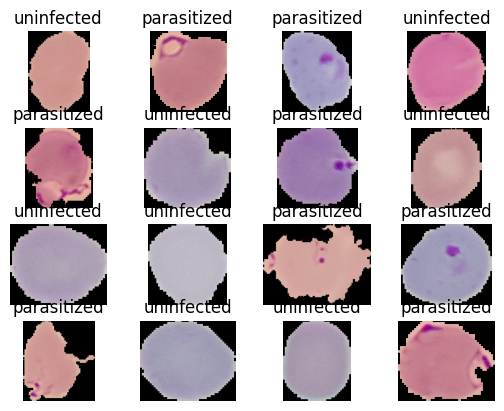

In [49]:
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)

    plt.imshow(image)
    plt.title(dataset_info.features["label"].int2str(label))
    plt.axis("off")

In [50]:
display(dataset_info.features["label"])
display(dataset_info.features["label"].int2str(0))
display(dataset_info.features["label"].int2str(1))

ClassLabel(shape=(), dtype=int64, num_classes=2)

'parasitized'

'uninfected'

# Data Preprocessing

### Data Augmentation

In [51]:
def visualize(image, label):
    plt.subplot(1, 1, 1)
    plt.imshow(image)
    plt.title(dataset_info.features["label"].int2str(label))
    plt.axis("off")


def visualize_aug(original, augmented):
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.subplot(1, 2, 2)
    plt.imshow(augmented)

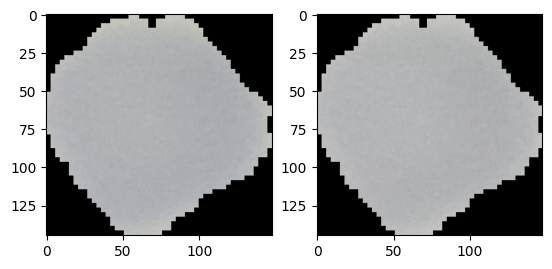

In [52]:
original_image, label = next(iter(train_dataset))
augmented_image = tf.image.adjust_saturation(original_image, saturation_factor=0.3)
visualize_aug(original_image, augmented_image)

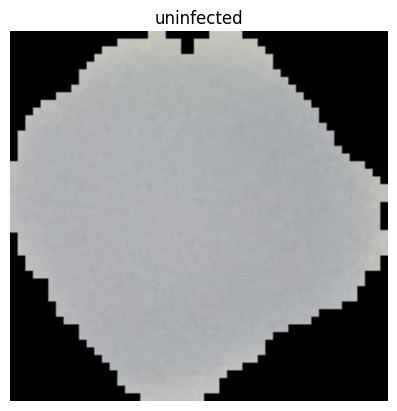

In [53]:
IM_SIZE = 224


@tf.function
def resize_rescale(image, label):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE)) / 255.0, label


original_image, label = next(iter(train_dataset))
o, l = resize_rescale(original_image, label)
visualize(original_image, label)

In [54]:
resize_rescale_layers = tf.keras.Sequential(
    [
        Resizing(IM_SIZE, IM_SIZE),
        Rescaling(1.0 / 255),
    ]
)

In [55]:
@tf.function
def augment(image, label):
    image, label = resize_rescale(image, label)
    image = tf.image.rot90(image)
    image = tf.image.flip_left_right(image)
    return image, label

In [56]:
class RotNinety(Layer):
    def __init__(self):
        super().__init__()

    @tf.function
    def call(self, image):
        return tf.image.rot90(image)

In [57]:
augment_layers = tf.keras.Sequential(
    [
        RandomRotation(factor=(0.25, 0.2501)),
        RandomFlip(mode="horizontal"),
        RandomContrast(factor=0.1),
    ]
)


@tf.function
def augment_layer(image, label):
    return augment_layers(resize_rescale_layers(image), training=True), label

### Data Loading

In [58]:
BATCH_SIZE = 32

In [59]:
test_dataset = test_dataset.map(resize_rescale, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = (
    train_dataset.shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .map(resize_rescale, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
val_dataset = (
    val_dataset.shuffle(buffer_size=32)
    .map(resize_rescale, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
)

# Model Creation and Training

### Functional API

In [60]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name="Input Image")
x = Conv2D(filters=6, kernel_size=3, strides=1, padding="valid", activation="relu")(
    func_input
)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

x = Conv2D(filters=16, kernel_size=3, strides=1, padding="valid", activation="relu")(x)
x = MaxPool2D(pool_size=2, strides=2)(x)
x = Flatten()(x)
x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation="relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation="sigmoid")(x)

feature_extractor_model = Model(func_input, func_output, name="Feature_Extractor")
feature_extractor_model.summary()

Model: "Feature_Extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input Image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,233 (17.81 MB)

 Trainable params: 4,668,001 (17.81 MB)

 Non-trainable params: 232 (928.00 B)

# Callbacks

In [61]:
class LossCallBack(Callback):
    def on_epoch_end(self, epoch, logs):
        print(
            f"\n For Epoch Number {epoch + 1}, the model has a loss of {logs['loss']}"
        )

    def on_batch_end(self, batch, logs):
        print(f"\n For Batch Number {batch+1}, the model has a loss of {logs}")

In [62]:
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=2,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

In [63]:
CURRENT_TIME = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
METRIC_DIR = "logs/" + CURRENT_TIME + "/metrics"
train_writer = tf.summary.create_file_writer(METRIC_DIR)

In [64]:
LOG_DIR = "logs/" + CURRENT_TIME

### Graph

In [65]:
graph_writer = tf.summary.create_file_writer(LOG_DIR)

tf.summary.trace_on(graph=True, profiler=False)

# 한 배치만 forward (모델이 build/trace되도록)
x0, y0 = next(iter(train_dataset.take(1)))
_ = feature_extractor_model(x0, training=False)

with graph_writer.as_default():
    tf.summary.trace_export(name="model_graph", step=0)

graph_writer.flush()

### LearningRateScheduler

In [66]:
def lr_scheduler(epoch, lr):
    if epoch <= 1:
        learning_rate = lr
    else:
        learning_rate = lr * tf.math.exp(-0.1)
        learning_rate = learning_rate.numpy()

    with train_writer.as_default():
        tf.summary.scalar("Learning Rate", data=learning_rate, step=epoch)
    return learning_rate


scheduler_callback = LearningRateScheduler(lr_scheduler, verbose=1)

# Training

In [67]:
OPTIMIZER = Adam(learning_rate=0.01)
METRIC = BinaryAccuracy()
METRIC_VAL = BinaryAccuracy()
EPOCH = 100

In [68]:
CUSTOM_TRAIN_DIR = "logs/" + CURRENT_TIME + "/custom/train"
CUSTOM_VAL_DIR = "logs/" + CURRENT_TIME + "/custom/val"

custom_train_writer = tf.summary.create_file_writer(CUSTOM_TRAIN_DIR)
custom_val_writer = tf.summary.create_file_writer(CUSTOM_VAL_DIR)

metrics = [
    TruePositives(name="tp"),
    FalsePositives(name="fp"),
    TrueNegatives(name="tn"),
    FalseNegatives(name="fn"),
    BinaryAccuracy(name="accuracy"),
    Precision(name="precision"),
    Recall(name="recall"),
    AUC(name="auc"),
]

In [69]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [70]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=LOG_DIR,
    histogram_freq=1,
    write_graph=False,
)  # Enable histogram computation with each epoch.

In [71]:
feature_extractor_model.compile(
    optimizer=OPTIMIZER, loss=BinaryCrossentropy(), metrics=metrics
)

history = feature_extractor_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=2,
    verbose=1,
    callbacks=[tensorboard_callback, scheduler_callback, early_stop_callback],
)


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/2
689/689 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.8698 - auc: 0.9361 - fn: 1289.0000 - fp: 1581.0000 - loss: 0.3204 - precision: 0.8603 - recall: 0.8831 - tn: 9439.0000 - tp: 9737.0000 - val_accuracy: 0.9401 - val_auc: 0.9721 - val_fn: 43.0000 - val_fp: 122.0000 - val_loss: 0.2321 - val_precision: 0.9164 - val_recall: 0.9688 - val_tn: 1253.0000 - val_tp: 1337.0000 - learning_rate: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/2
689/689 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.9320 - auc: 0.9647 - fn: 610.0000 - fp: 890.0000 - loss: 0.2139 - precision: 0.9212 - recall: 0.9446 - tn: 10136.0000 - tp: 10410.0000 - val_accuracy: 0.9289 - val_auc: 0.9627 - val_fn: 32.0000 - val_fp: 164.0000 - val_loss: 0.4391 - val_precision: 0.8939 - val_recall: 0.9774 - val_tn: 1177.0000 - val_tp: 1382.0000 - learning_rate: 0.0100


In [72]:
%tensorboard --logdir ./logs

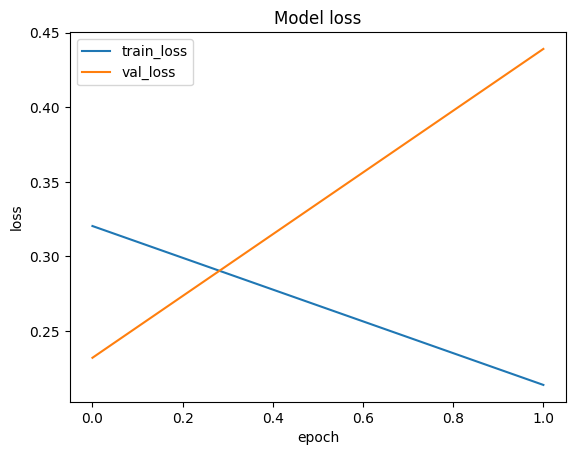

In [73]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train_loss", "val_loss"])
plt.show()

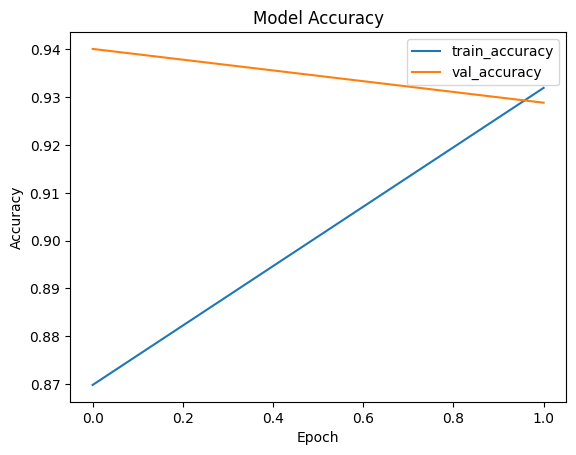

In [74]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["train_accuracy", "val_accuracy"])
plt.show()

In [75]:
labels = []
inp = []
# for t in test_dataset:
#   print(t)
#   break
for x, y in test_dataset.as_numpy_iterator():
    labels.append(y)
    inp.append(x)

2026-01-18 03:41:30.436290: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [76]:
predicted = feature_extractor_model.predict(np.array(inp))

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


[[1210  177]
 [  31 1339]]


Text(0.5, 58.7222222222222, 'Predicted')

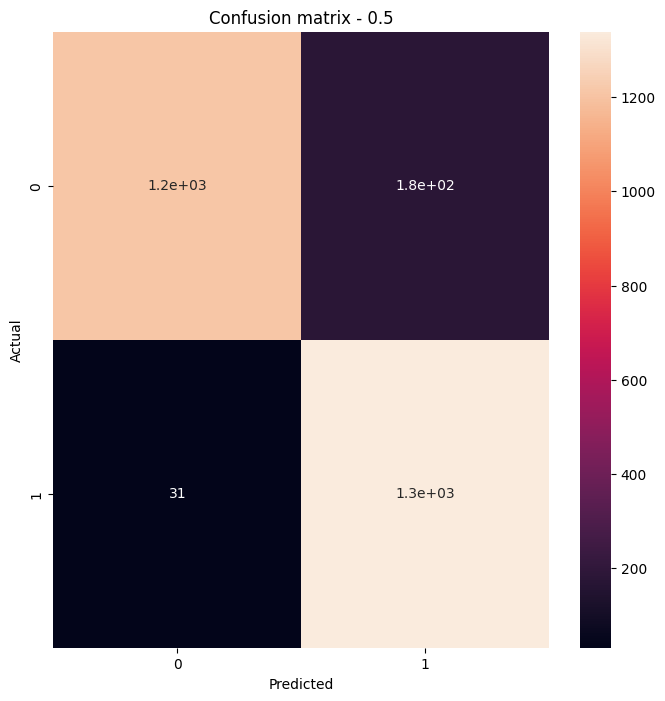

In [77]:
threshold = 0.5

cm = confusion_matrix(labels, predicted > threshold)
print(cm)
plt.figure(figsize=(8, 8))

sns.heatmap(
    cm,
    annot=True,
)
plt.title("Confusion matrix - {}".format(threshold))
plt.ylabel("Actual")
plt.xlabel("Predicted")